In [1]:
# Init

%matplotlib inline

import csv
import itertools
import math
import matplotlib
import time
import logging
import sys
import os
import random
import warnings

import gensim

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm_notebook as tqdm
from collections import Counter, defaultdict

from sklearn import random_projection
from sklearn.manifold import TSNE
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, spdiags
from scipy.io import loadmat, savemat
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, MultiLabelBinarizer
from gensim.models import KeyedVectors

from scoring import scoring
from fastrp_exp import *

# to ignore sklearn warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')

plt.rcParams['font.size'] = 11
plt.rcParams['figure.autolayout'] = True

# Generate ER Graphs

In [4]:
def gen_er_graph(n, deg):
    er_graph = nx.generators.random_graphs.fast_gnp_random_graph(n, 1. * deg / (n - 1))
    for i in range(n):
        if er_graph.degree(i) == 0:
            r = random.randint(0, n - 1)
            while r == i:
                r = random.randint(0, n - 1)
            er_graph.add_edge(i, r)
            
    return er_graph

def nx_graph_to_csr(G):
    rows, cols = [], []

    for node in G.nodes():
        for adj_node in G[node]:
            rows.append(node)
            cols.append(adj_node)
    A = csr_matrix( ([1.0] * len(rows), (rows, cols)), shape=(G.number_of_nodes(), G.number_of_nodes()) )
    return A

In [7]:
A = nx_graph_to_csr(gen_er_graph(1000, 10) )

In [8]:
A

<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 10120 stored elements in Compressed Sparse Row format>

In [13]:
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [0.0, 0.0, 1.0, 4.836],
        'normalization': False,
        'dim': 512,
        'alpha': -0.6,
        'C': 0.1
    }

The next two cells are only for sanity check (making sure they are both measuring CPU time):

In [10]:
%%time
U = fastrp_wrapper(A, conf)

CPU times: user 90.8 ms, sys: 5.3 ms, total: 96.1 ms
Wall time: 65.4 ms


In [11]:
before = time.process_time()
U = fastrp_wrapper(A, conf)
after = time.process_time()
print (after - before)

0.05760140800000002


# Run FastRP

## Change n

In [14]:
n_time_map = {}
m = 10**7
for n in range(10**5, 10**6+1, 10**5):
    print (n)
    A = nx_graph_to_csr(gen_er_graph(n, m / n) )
    before = time.process_time()
    U = fastrp_wrapper(A, conf)
    after = time.process_time()
    print (after - before)
    n_time_map[n] = after - before

100000
36.188140492
200000
47.897716325999994
300000
63.641572836999984
400000
75.45048314499996
500000
86.66139583199998
600000
96.75731120500001
700000
103.63986084999999
800000
116.640068165
900000
122.29481019299988
1000000
130.40500873399992


In [2]:
import matplotlib.ticker as ticker

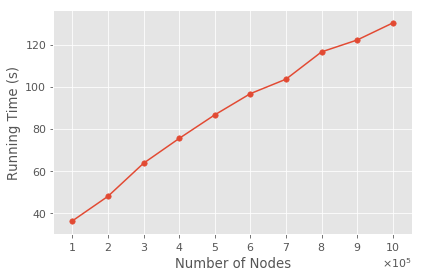

In [44]:
metric = r'Running Time(s)$'
p = pd.DataFrame(n_time_map, index=[metric]).transpose()

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.plot(p.index, p[metric], linewidth=1.5)
ax.scatter(x=p.index, y=p[metric], s=30)
ax.ticklabel_format(style='sci', axis='x', scilimits=(5,5), useMathText=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(100000))

ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Running Time (s)')
fig.savefig('figures/run_time_n.pdf')

# fig.savefig('../paper/Figures/run_time_er_dw.pdf')

# Change m

In [ ]:
m_time_map = {}
m = 10**6
for m in range(10**7, 10**8+1, 10**7):
    print (m)
    A = nx_graph_to_csr(gen_er_graph(n, m / n) )
    before = time.process_time()
    U = fastrp_wrapper(A, conf)
    after = time.process_time()
    print (after - before)
    m_time_map[m] = after - before

10000000
130.77612258199997
20000000
159.78609798499997
30000000
180.13797692999992
40000000
202.06579397799987
50000000


In [17]:
m_time_map

{10000000: 130.77612258199997,
 20000000: 159.78609798499997,
 30000000: 180.13797692999992,
 40000000: 202.06579397799987,
 50000000: 227.0333807269999,
 60000000: 246.30138820899992,
 70000000: 268.5734591219998,
 80000000: 289.7249463469998,
 90000000: 320.8279620430003,
 100000000: 334.02417479199994}

In [4]:
m_time_map = {10000000: 130.77612258199997,
 20000000: 159.78609798499997,
 30000000: 180.13797692999992,
 40000000: 202.06579397799987,
 50000000: 227.0333807269999,
 60000000: 246.30138820899992,
 70000000: 268.5734591219998,
 80000000: 289.7249463469998,
 90000000: 320.8279620430003,
 100000000: 334.02417479199994}

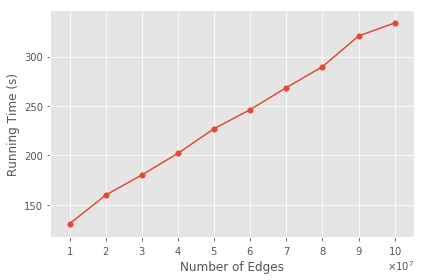

In [10]:
metric = r'Running Time(s)$'
p = pd.DataFrame(m_time_map, index=[metric]).transpose()

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.plot(p.index, p[metric], linewidth=1.5)
ax.scatter(x=p.index, y=p[metric], s=30)
ax.ticklabel_format(style='sci', axis='x', scilimits=(7,7), useMathText=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10000000))

ax.set_xlabel('Number of Edges')
ax.set_ylabel('Running Time (s)')
fig.savefig('figures/run_time_m.pdf')

# fig.savefig('../paper/Figures/run_time_er_dw.pdf')